# Problem Statement

To predict the winner of a T20 cricket match using historical match and ball-by-ball data, by identifying key factors that influence outcomes and building machine learning models for reliable predictions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

## Data Collection

The data has been collected from [Cricsheet](https://cricsheet.org/) which stores ball by ball data for all historical t20 matches.

In [2]:
df = pd.read_csv("data/matches.csv")
df.head()

,team1,team2,date,venue,outcome,venue_innings_avg_total,venue_avg_run_per_over,venue_avg_runs_per_wicket,team1_current_rating,team2_current_rating,elo_diff
0,Australia,New Zealand,2005-02-17,Eden Park,Australia,157.964286,8.509125,33.183390,1500.0000,1500.0000,0.0000
1,England,Australia,2005-06-13,The Rose Bowl,England,158.281250,7.891814,31.879018,1500.0000,1515.0000,-15.0000
2,South Africa,New Zealand,2005-10-21,New Wanderers Stadium,New Zealand,161.132353,8.258908,34.798264,1500.0000,1485.0000,15.0000
3,Australia,South Africa,2006-01-09,Brisbane Cricket Ground,Australia,149.550000,8.283155,30.909722,1499.3528,1484.3528,15.0000
4,South Africa,Australia,2006-02-24,New Wanderers Stadium,South Africa,161.132353,8.258908,34.798264,1470.0000,1513.7056,-43.7056


## Initial Data Checks

- check missing values
- check duplicates
- check data types
- check number of unique values in each categorical column
- check statistics of numerical columns

### check missing values

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   team1                      1800 non-null   object 
 1   team2                      1800 non-null   object 
 2   date                       1800 non-null   object 
 3   venue                      1800 non-null   object 
 4   outcome                    1800 non-null   object 
 5   venue_innings_avg_total    1800 non-null   float64
 6   venue_avg_run_per_over     1800 non-null   float64
 7   venue_avg_runs_per_wicket  1800 non-null   float64
 8   team1_current_rating       1800 non-null   float64
 9   team2_current_rating       1800 non-null   float64
 10  elo_diff                   1800 non-null   float64
dtypes: float64(6), object(5)
memory usage: 154.8+ KB


there are no missing values in any column

### Check Duplicates

In [4]:
df.duplicated(subset=['team1', 'team2', 'date']).sum()

np.int64(8)

there are 8 duplicates in total

In [5]:
df.drop_duplicates(subset=['team1', 'team2', 'date'], inplace=True)

### Check data types

In [6]:
cat_cols = [col for col in df.columns if df[col].dtype == 'O']
num_cols = [col for col in df.columns if df[col].dtype != 'O']

print(f"total {len(cat_cols)} categorical columns:")
for col in cat_cols:
    print(col)

print("==============================")

print(f"total {len(num_cols)} numerical columns")
for col in num_cols:
    print(col)

total 5 categorical columns:
team1
team2
date
venue
outcome
total 6 numerical columns
venue_innings_avg_total
venue_avg_run_per_over
venue_avg_runs_per_wicket
team1_current_rating
team2_current_rating
elo_diff


### number of unique values in each categorical column

In [7]:
for col in cat_cols:
    print(f"{col}: total {len(df[col].unique())} unique values")

team1: total 15 unique values
team2: total 15 unique values
date: total 1334 unique values
venue: total 179 unique values
outcome: total 15 unique values


### statistics of numerical columns

In [8]:
df.describe()

,venue_innings_avg_total,venue_avg_run_per_over,venue_avg_runs_per_wicket,team1_current_rating,team2_current_rating,elo_diff
count,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000,1792.000000
mean,139.649451,7.217464,29.474930,1540.987334,1536.984724,4.002610
std,17.106020,0.794180,5.859701,122.436288,124.752285,147.076071
min,64.000000,3.564027,8.521429,1260.337056,1259.217141,-440.575381
25%,130.333333,6.721610,25.930195,1453.459771,1437.885891,-85.348293
50%,139.166667,7.199593,28.881243,1545.460248,1540.809046,3.440838
75%,152.000000,7.818066,32.563457,1628.785769,1626.905865,88.628158
max,217.500000,10.672354,79.000000,1875.318583,1878.778585,445.717222


the numerical columns seem to have too many digits after decimal. rounding down to 2 decimal is sufficient

In [9]:
for col in num_cols:
    df[col] = df[col].round(2)

df[num_cols].head()

,venue_innings_avg_total,venue_avg_run_per_over,venue_avg_runs_per_wicket,team1_current_rating,team2_current_rating,elo_diff
0,157.96,8.51,33.18,1500.00,1500.00,0.00
1,158.28,7.89,31.88,1500.00,1515.00,-15.00
2,161.13,8.26,34.80,1500.00,1485.00,15.00
3,149.55,8.28,30.91,1499.35,1484.35,15.00
4,161.13,8.26,34.80,1470.00,1513.71,-43.71


## Exploratory Analysis

### Rating Difference

does rating difference have a strong impact on outcome?

/tmp/ipykernel_39787/3907693163.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_by_bucket = df.groupby('elo_diff_bucket')['team1_win'].mean()


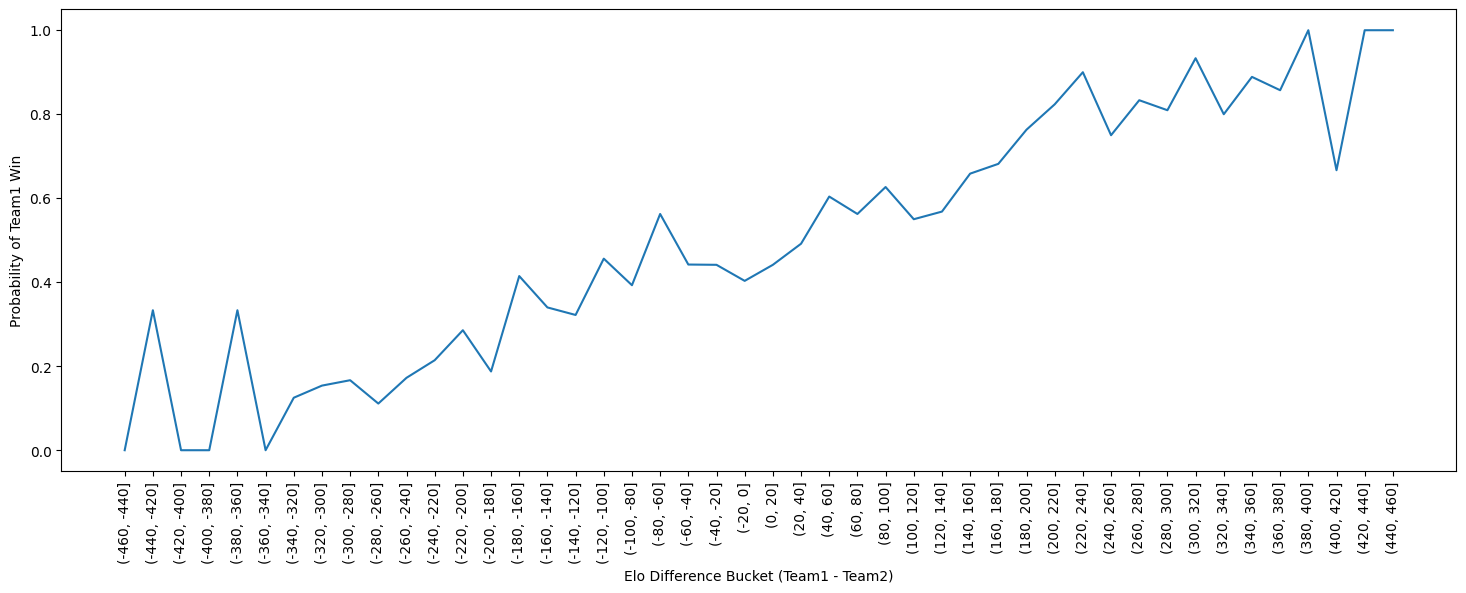

In [10]:
min_elo_diff = df.elo_diff.min()
max_elo_diff = df.elo_diff.max()

df['team1_win'] = (df['outcome'] == df['team1']).astype(int)


df['elo_diff_bucket'] = pd.cut(df['elo_diff'], bins=range(int(min_elo_diff)-20, int(max_elo_diff)+20, 20))


prob_by_bucket = df.groupby('elo_diff_bucket')['team1_win'].mean()

plt.figure(figsize=(18,6))
sns.lineplot(x=prob_by_bucket.index.astype(str), y=prob_by_bucket.values)
plt.xticks(rotation=90)
plt.xlabel("Elo Difference Bucket (Team1 - Team2)")
plt.ylabel("Probability of Team1 Win")
plt.show()


rating difference seems to have a very strong correlation with win probability

### Average innings total by venues

does average innigs total for a venue have an impact on win probability?

/tmp/ipykernel_39787/757215442.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_by_bucket = df.groupby('avg_inn_tot_bucket')['team1_win'].mean()


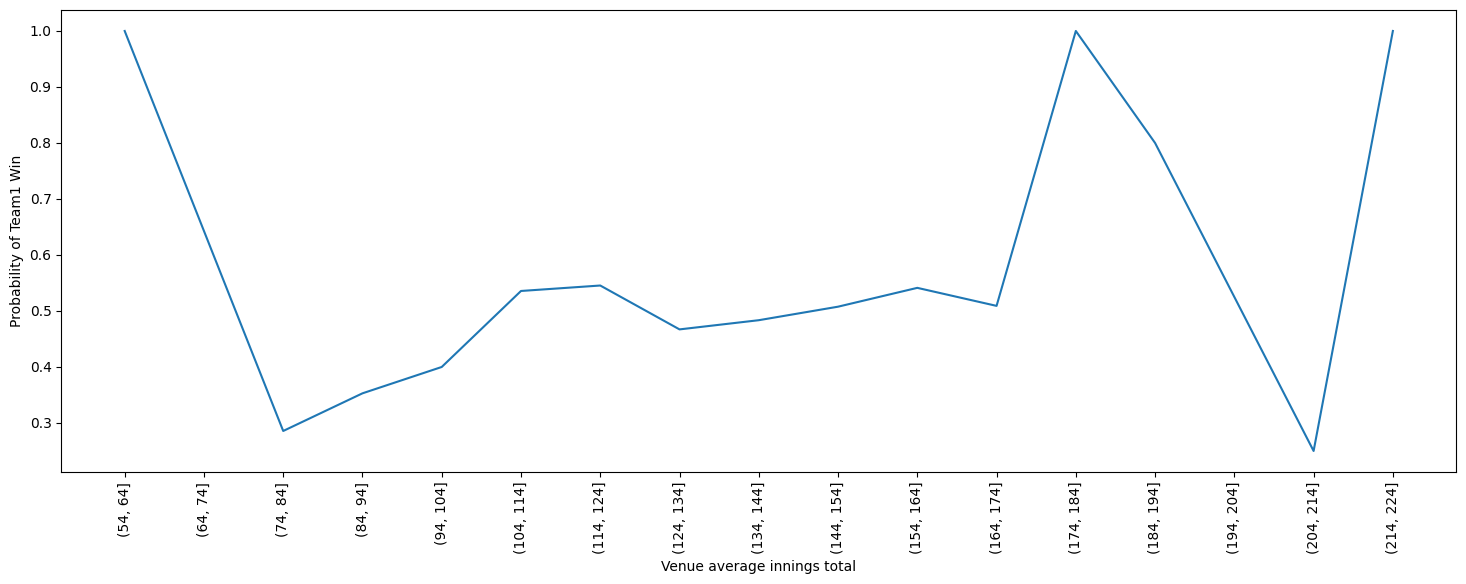

In [11]:
min_inn_tot = df.venue_innings_avg_total.min()
max_inn_tot = df.venue_innings_avg_total.max()

df['avg_inn_tot_bucket'] = pd.cut(df['venue_innings_avg_total'], bins=range(int(min_inn_tot)-10, int(max_elo_diff)+10, 10))


prob_by_bucket = df.groupby('avg_inn_tot_bucket')['team1_win'].mean()

plt.figure(figsize=(18,6))
sns.lineplot(x=prob_by_bucket.index.astype(str), y=prob_by_bucket.values)
plt.xticks(rotation=90)
plt.xlabel("Venue average innings total")
plt.ylabel("Probability of Team1 Win")
plt.show()


there seems to be no correlation between average score at a value and win probability

### venue average runs per over

/tmp/ipykernel_39787/2828368742.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_by_bucket = df.groupby('rpo_bucket')['team1_win'].mean()


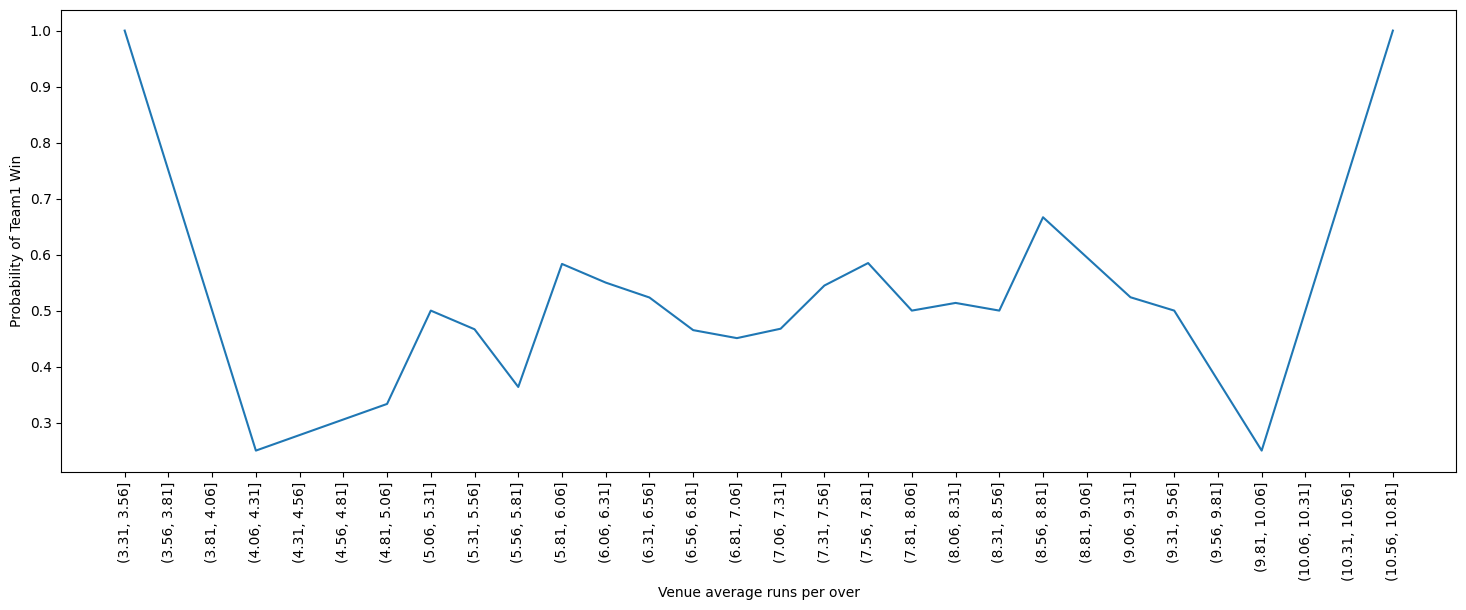

In [12]:
min_rpo = df.venue_avg_run_per_over.min()
max_rpo = df.venue_avg_run_per_over.max()

df['rpo_bucket'] = pd.cut(
    df['venue_avg_run_per_over'],
    bins=np.arange(min_rpo - 0.25, max_rpo + 0.25, 0.25)
)


prob_by_bucket = df.groupby('rpo_bucket')['team1_win'].mean()

plt.figure(figsize=(18,6))
sns.lineplot(x=prob_by_bucket.index.astype(str), y=prob_by_bucket.values)
plt.xticks(rotation=90)
plt.xlabel("Venue average runs per over")
plt.ylabel("Probability of Team1 Win")
plt.show()


there seems to be no particular relation

### venue average runs per wicket

/tmp/ipykernel_39787/3559926351.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_by_bucket = df.groupby('rpw_bucket')['team1_win'].mean()


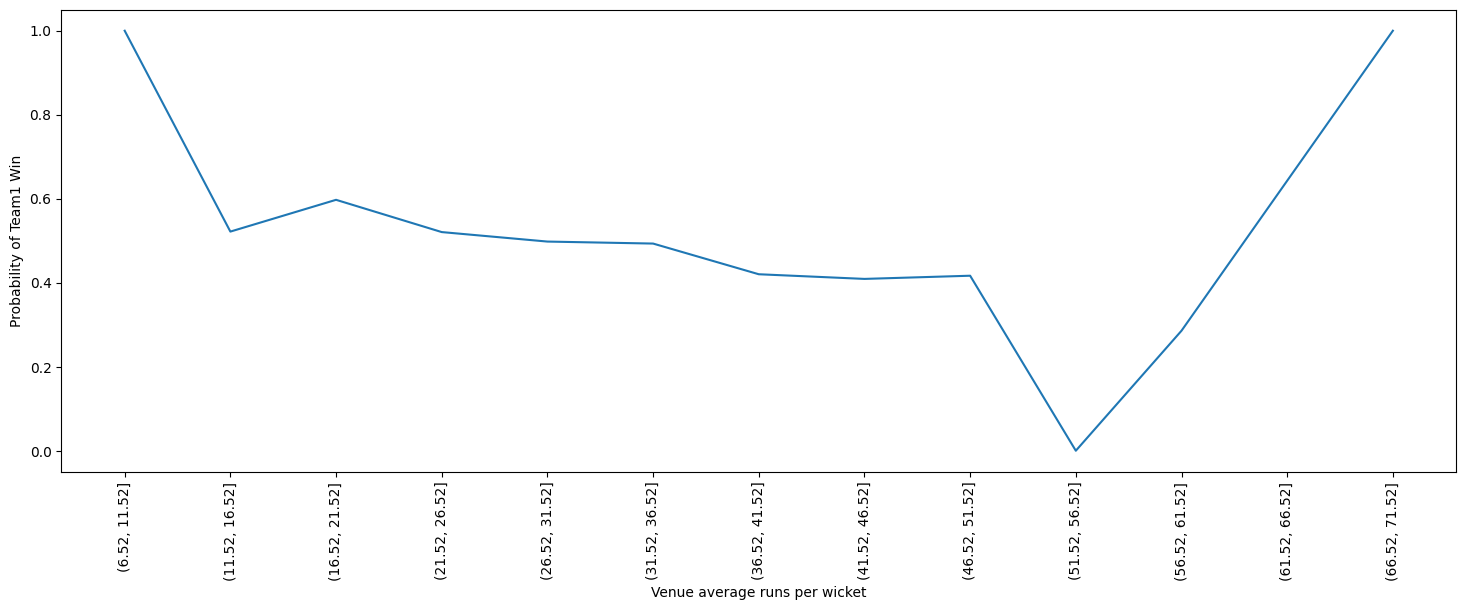

In [13]:
min_rpw = df.venue_avg_runs_per_wicket.min()
max_rpw = df.venue_avg_runs_per_wicket.max()

df['rpw_bucket'] = pd.cut(
    df['venue_avg_runs_per_wicket'],
    bins=np.arange(min_rpw - 2.0, max_rpw + 2.0, 5)
)


prob_by_bucket = df.groupby('rpw_bucket')['team1_win'].mean()

plt.figure(figsize=(18,6))
sns.lineplot(x=prob_by_bucket.index.astype(str), y=prob_by_bucket.values)
plt.xticks(rotation=90)
plt.xlabel("Venue average runs per wicket")
plt.ylabel("Probability of Team1 Win")
plt.show()


there seems to be a slight downward trend

### team current rating

/tmp/ipykernel_39787/4184858565.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_by_bucket = df.groupby('elo_bucket')['team1_win'].mean()


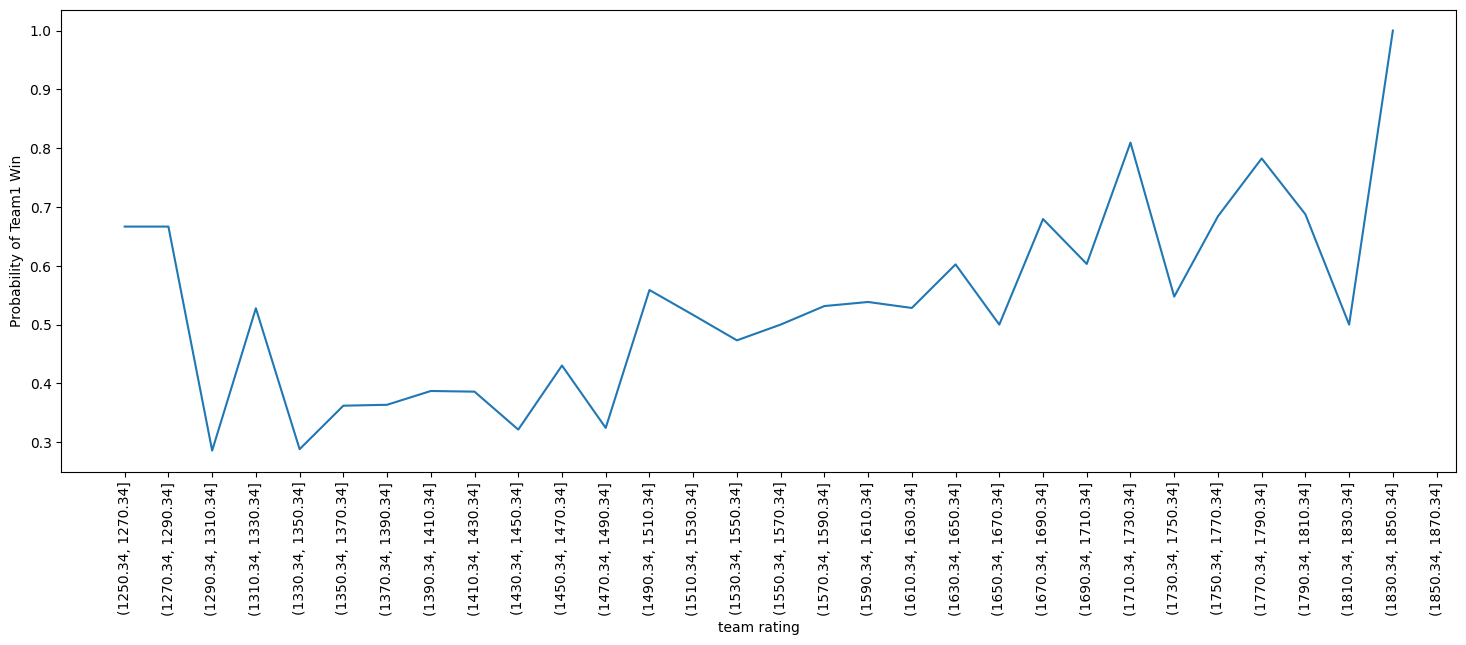

In [14]:
min_elo = df.team1_current_rating.min()
max_elo = df.team1_current_rating.max()

df['elo_bucket'] = pd.cut(
    df['team1_current_rating'],
    bins=np.arange(min_elo - 10, max_elo + 10, 20)
)


prob_by_bucket = df.groupby('elo_bucket')['team1_win'].mean()

plt.figure(figsize=(18,6))
sns.lineplot(x=prob_by_bucket.index.astype(str), y=prob_by_bucket.values)
plt.xticks(rotation=90)
plt.xlabel("team rating")
plt.ylabel("Probability of Team1 Win")
plt.show()


there seems to be a slight positive correlation

### venue clusters

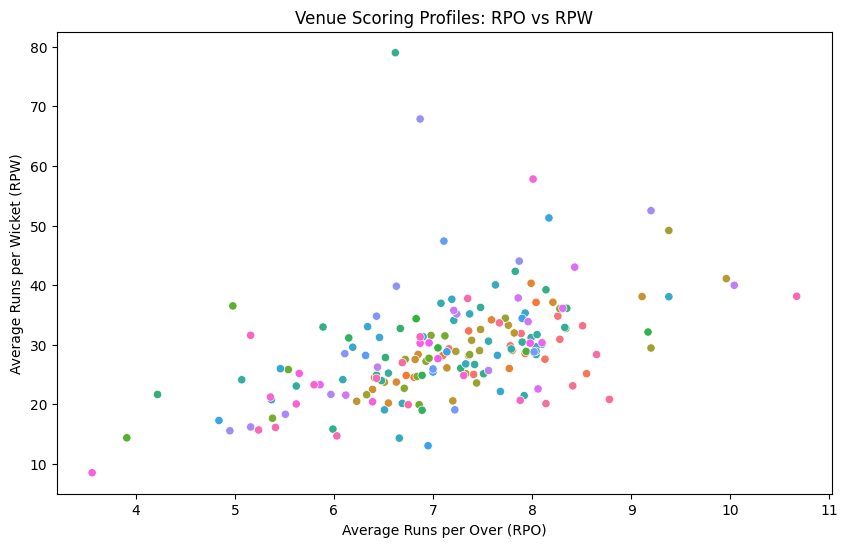

In [15]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df.drop_duplicates('venue'),   # one point per venue
    x='venue_avg_run_per_over',
    y='venue_avg_runs_per_wicket',
    hue='venue',    # optional: color by venue
    legend=False    # turn off legend if too many venues
)

plt.xlabel("Average Runs per Over (RPO)")
plt.ylabel("Average Runs per Wicket (RPW)")
plt.title("Venue Scoring Profiles: RPO vs RPW")

plt.show()

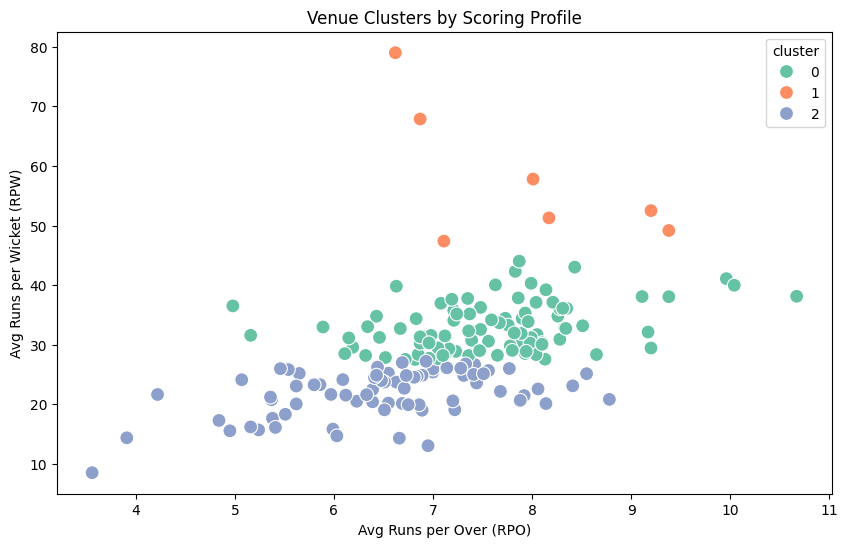

In [16]:
venue_stats = df.groupby('venue').agg({
    'venue_avg_run_per_over': 'mean',
    'venue_avg_runs_per_wicket': 'mean',
    'team1_win': 'mean',   # just to have some outcome context
}).reset_index()

X = venue_stats[['venue_avg_run_per_over', 'venue_avg_runs_per_wicket']]

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
venue_stats['cluster'] = kmeans.fit_predict(X)

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=venue_stats,
    x='venue_avg_run_per_over',
    y='venue_avg_runs_per_wicket',
    hue='cluster',
    palette='Set2',
    s=100
)

plt.xlabel("Avg Runs per Over (RPO)")
plt.ylabel("Avg Runs per Wicket (RPW)")
plt.title("Venue Clusters by Scoring Profile")
plt.show()


In [17]:
df['stronger_team'] = df.apply(
    lambda row: row['team1'] if row['elo_diff'] >= 0 else row['team2'],
    axis=1
)

df['stronger_team_win'] = (df['outcome'] == df['stronger_team']).astype(int)

df = df.merge(venue_stats[['venue','cluster']], on='venue')

cluster_outcomes = df.groupby('cluster')['stronger_team_win'].mean()
print(cluster_outcomes)

cluster
0    0.631877
1    0.565217
2    0.606004
Name: stronger_team_win, dtype: float64


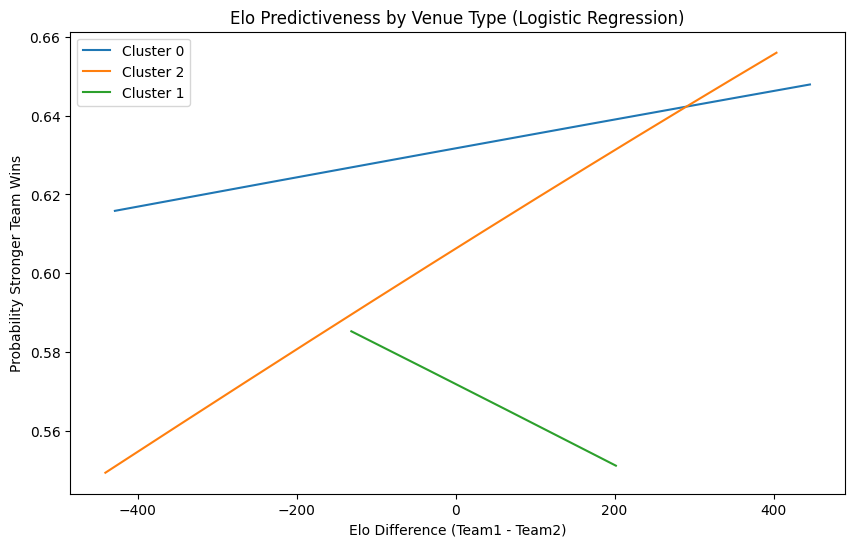

In [ ]:
plt.figure(figsize=(10,6))

for cluster in df['cluster'].unique():
    temp = df[df['cluster']==cluster]
    X = temp['elo_diff'].values.reshape(-1,1)
    y = temp['stronger_team_win']

    model = LogisticRegression()
    model.fit(X, y)

    x_vals = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
    y_pred = model.predict_proba(x_vals)[:,1]

    plt.plot(x_vals, y_pred, label=f"Cluster {cluster}")

plt.xlabel("Elo Difference (Team1 - Team2)")
plt.ylabel("Probability Stronger Team Wins")
plt.title("Elo Predictiveness by Venue Type (Logistic Regression)")
plt.legend()
plt.show()
